<a href="https://colab.research.google.com/github/jordanbell2357/uscg-nais-data/blob/main/BigQuery/MMSI_538008861.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# @title Setup
from google.colab import auth
from google.cloud import bigquery
from google.colab import data_table

project = 'ais-data-385301' # Project ID inserted based on the query results selected to explore
location = 'US' # Location inserted based on the query results selected to explore
client = bigquery.Client(project=project, location=location)
data_table.enable_dataframe_formatter()
auth.authenticate_user()

## Reference SQL syntax from the original job
Use the ```jobs.query```
[method](https://cloud.google.com/bigquery/docs/reference/rest/v2/jobs/query) to
return the SQL syntax from the job. This can be copied from the output cell
below to edit the query now or in the future. Alternatively, you can use
[this link](https://console.cloud.google.com/bigquery?j=ais-data-385301:US:bquxjob_62757a4a_1886ee79277)
back to BigQuery to edit the query within the BigQuery user interface.

In [3]:
# Running this code will display the query used to generate your previous job

job = client.get_job('bquxjob_62757a4a_1886ee79277') # Job ID inserted based on the query results selected to explore
print(job.query)

SELECT * FROM `ais-data-385301.uscg.nais` WHERE MMSI = '538008861' ORDER BY BaseDateTime ASC;


# Result set loaded from BigQuery job as a DataFrame
Query results are referenced from the Job ID ran from BigQuery and the query
does not need to be re-run to explore results. The ```to_dataframe```
[method](https://googleapis.dev/python/bigquery/latest/generated/google.cloud.bigquery.job.QueryJob.html#google.cloud.bigquery.job.QueryJob.to_dataframe)
downloads the results to a Pandas DataFrame by using the BigQuery Storage API.

To edit query syntax, you can do so from the BigQuery SQL editor or in the
```Optional:``` sections below.

In [4]:
# Running this code will read results from your previous job

job = client.get_job('bquxjob_62757a4a_1886ee79277') # Job ID inserted based on the query results selected to explore
results = job.to_dataframe()

In [17]:
results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26288 entries, 0 to 26287
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype              
---  ------            --------------  -----              
 0   MMSI              26288 non-null  object             
 1   BaseDateTime      26288 non-null  datetime64[ns, UTC]
 2   LAT               26288 non-null  float64            
 3   LON               26288 non-null  float64            
 4   SOG               26288 non-null  float64            
 5   COG               26288 non-null  float64            
 6   Heading           26288 non-null  float64            
 7   VesselName        26288 non-null  object             
 8   IMO               26288 non-null  object             
 9   CallSign          26288 non-null  object             
 10  VesselType        26288 non-null  object             
 11  Status            26288 non-null  object             
 12  Length            26288 non-null  float64            
 13  W

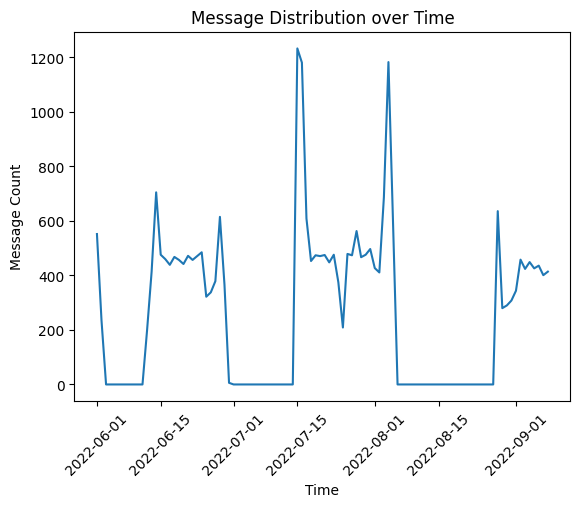

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# Parameters
interval = 'D'  # Choose the desired interval (e.g., 'H' for hour, '30min' for half hour, 'D' for day, 'W' for week)

# Convert the 'BaseDateTime' column to datetime type
results['BaseDateTime'] = pd.to_datetime(results['BaseDateTime'])

# Group the data by the specified interval
grouped_data = results.groupby(pd.Grouper(key='BaseDateTime', freq=interval))

# Count the number of messages for each interval
message_counts = grouped_data.size()

# Create a line plot of the message distribution over time
plt.plot(message_counts.index, message_counts.values)
plt.xlabel('Time')
plt.ylabel('Message Count')
plt.title('Message Distribution over Time')
plt.xticks(rotation=45)
plt.show()

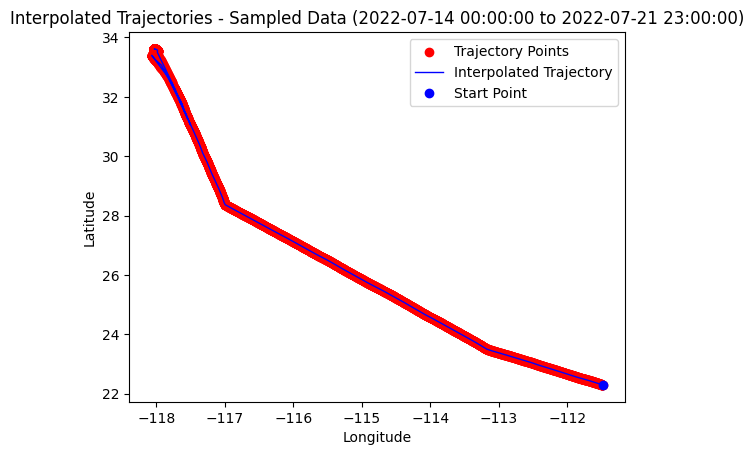

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# Parameters
start_date = pd.Timestamp('2022-07-14 00:00:00')  # Include the desired hour
end_date = pd.Timestamp('2022-07-21 23:00:00')  # Include the desired hour
sampling_rate = '15min'  # Options: '1min', '5min', '10min', '15min', '30min', '1H', '2H', '3H', ...

# Convert to timezone naive UTC by creating a copy of the DataFrame
df = results[['BaseDateTime', 'LAT', 'LON']].copy()
df['BaseDateTime'] = df['BaseDateTime'].dt.tz_convert('UTC').dt.tz_localize(None)

# Apply time cutoff
df = df[(df['BaseDateTime'] >= start_date) & (df['BaseDateTime'] <= end_date)]

# Resample the data to the specified sampling rate, keeping the first message in each interval
df.set_index('BaseDateTime', inplace=True)
sampled_data = df.resample(sampling_rate).first().dropna()

# Convert datetime to numerical values
time_vals = (sampled_data.index - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')

# Create an interpolation function for the latitude and longitude coordinates
interp_func = interp1d(
    time_vals,
    sampled_data[['LAT', 'LON']],
    kind='linear',
    axis=0,
    fill_value='extrapolate'
)

# Generate new time points for finer sampling
new_time_vals = np.arange(time_vals.min(), time_vals.max(), 60)  # 60 seconds for 1-minute frequency

# Interpolate the latitude and longitude coordinates at the new time points
new_coords = interp_func(new_time_vals)

# Create a scatter plot of the interpolated data
plt.scatter(
    new_coords[:, 1],
    new_coords[:, 0],
    c='red',
    marker='o',
    label='Trajectory Points'
)

# Create a line plot of the interpolated trajectory
plt.plot(
    new_coords[:, 1],
    new_coords[:, 0],
    '-',
    linewidth=1,
    color='blue',
    label='Interpolated Trajectory'
)

# Add a dot at the start of the trajectory
plt.plot(
    new_coords[0, 1],
    new_coords[0, 0],
    'bo',
    label='Start Point'
)

# Customize the plot
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Interpolated Trajectories - Sampled Data ({} to {})'.format(start_date, end_date))
plt.legend()

plt.show()

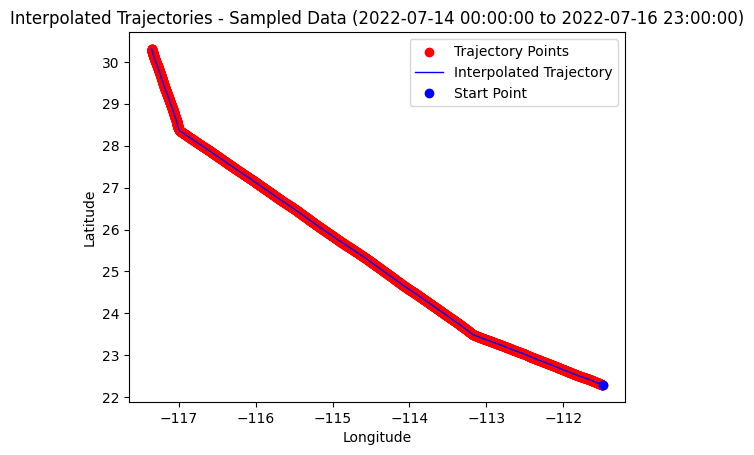

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# Parameters
start_date = pd.Timestamp('2022-07-14 00:00:00')  # Include the desired hour
end_date = pd.Timestamp('2022-07-16 23:00:00')  # Include the desired hour
sampling_rate = '15min'  # Options: '1min', '5min', '10min', '15min', '30min', '1H', '2H', '3H', ...

# Convert to timezone naive UTC by creating a copy of the DataFrame
df = results[['BaseDateTime', 'LAT', 'LON']].copy()
df['BaseDateTime'] = df['BaseDateTime'].dt.tz_convert('UTC').dt.tz_localize(None)

# Apply time cutoff
df = df[(df['BaseDateTime'] >= start_date) & (df['BaseDateTime'] <= end_date)]

# Resample the data to the specified sampling rate, keeping the first message in each interval
df.set_index('BaseDateTime', inplace=True)
sampled_data = df.resample(sampling_rate).first().dropna()

# Convert datetime to numerical values
time_vals = (sampled_data.index - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')

# Create an interpolation function for the latitude and longitude coordinates
interp_func = interp1d(
    time_vals,
    sampled_data[['LAT', 'LON']],
    kind='linear',
    axis=0,
    fill_value='extrapolate'
)

# Generate new time points for finer sampling
new_time_vals = np.arange(time_vals.min(), time_vals.max(), 60)  # 60 seconds for 1-minute frequency

# Interpolate the latitude and longitude coordinates at the new time points
new_coords = interp_func(new_time_vals)

# Create a scatter plot of the interpolated data
plt.scatter(
    new_coords[:, 1],
    new_coords[:, 0],
    c='red',
    marker='o',
    label='Trajectory Points'
)

# Create a line plot of the interpolated trajectory
plt.plot(
    new_coords[:, 1],
    new_coords[:, 0],
    '-',
    linewidth=1,
    color='blue',
    label='Interpolated Trajectory'
)

# Add a dot at the start of the trajectory
plt.plot(
    new_coords[0, 1],
    new_coords[0, 0],
    'bo',
    label='Start Point'
)

# Customize the plot
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Interpolated Trajectories - Sampled Data ({} to {})'.format(start_date, end_date))
plt.legend()

plt.show()

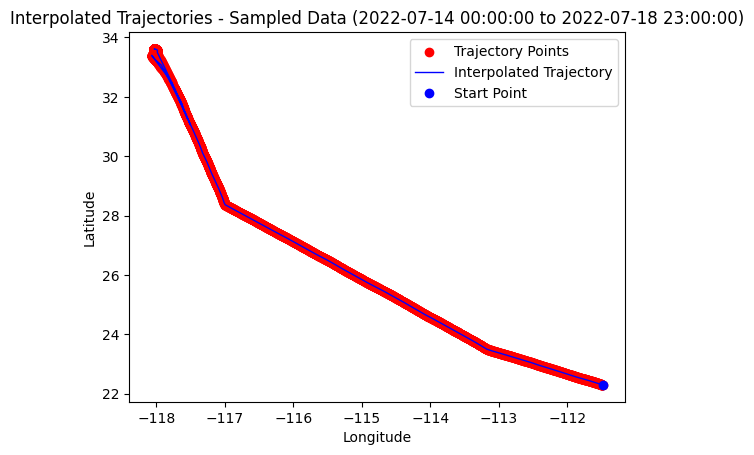

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# Parameters
start_date = pd.Timestamp('2022-07-14 00:00:00')  # Include the desired hour
end_date = pd.Timestamp('2022-07-18 23:00:00')  # Include the desired hour
sampling_rate = '15min'  # Options: '1min', '5min', '10min', '15min', '30min', '1H', '2H', '3H', ...

# Convert to timezone naive UTC by creating a copy of the DataFrame
df = results[['BaseDateTime', 'LAT', 'LON']].copy()
df['BaseDateTime'] = df['BaseDateTime'].dt.tz_convert('UTC').dt.tz_localize(None)

# Apply time cutoff
df = df[(df['BaseDateTime'] >= start_date) & (df['BaseDateTime'] <= end_date)]

# Resample the data to the specified sampling rate, keeping the first message in each interval
df.set_index('BaseDateTime', inplace=True)
sampled_data = df.resample(sampling_rate).first().dropna()

# Convert datetime to numerical values
time_vals = (sampled_data.index - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')

# Create an interpolation function for the latitude and longitude coordinates
interp_func = interp1d(
    time_vals,
    sampled_data[['LAT', 'LON']],
    kind='linear',
    axis=0,
    fill_value='extrapolate'
)

# Generate new time points for finer sampling
new_time_vals = np.arange(time_vals.min(), time_vals.max(), 60)  # 60 seconds for 1-minute frequency

# Interpolate the latitude and longitude coordinates at the new time points
new_coords = interp_func(new_time_vals)

# Create a scatter plot of the interpolated data
plt.scatter(
    new_coords[:, 1],
    new_coords[:, 0],
    c='red',
    marker='o',
    label='Trajectory Points'
)

# Create a line plot of the interpolated trajectory
plt.plot(
    new_coords[:, 1],
    new_coords[:, 0],
    '-',
    linewidth=1,
    color='blue',
    label='Interpolated Trajectory'
)

# Add a dot at the start of the trajectory
plt.plot(
    new_coords[0, 1],
    new_coords[0, 0],
    'bo',
    label='Start Point'
)

# Customize the plot
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Interpolated Trajectories - Sampled Data ({} to {})'.format(start_date, end_date))
plt.legend()

plt.show()

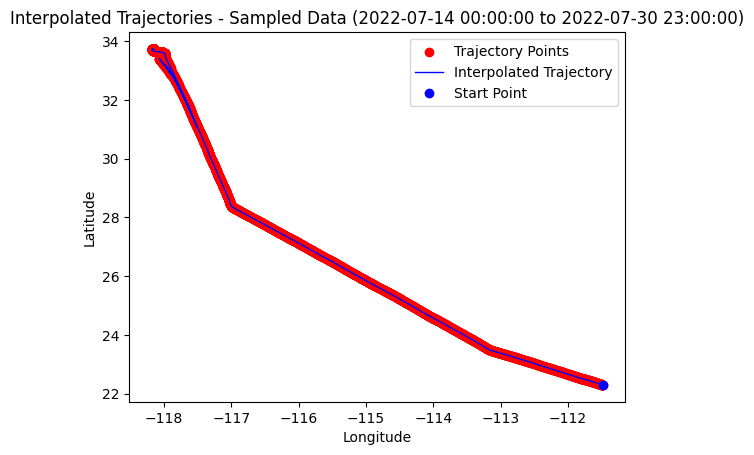

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# Parameters
start_date = pd.Timestamp('2022-07-14 00:00:00')  # Include the desired hour
end_date = pd.Timestamp('2022-07-30 23:00:00')  # Include the desired hour
sampling_rate = '15min'  # Options: '1min', '5min', '10min', '15min', '30min', '1H', '2H', '3H', ...

# Convert to timezone naive UTC by creating a copy of the DataFrame
df = results[['BaseDateTime', 'LAT', 'LON']].copy()
df['BaseDateTime'] = df['BaseDateTime'].dt.tz_convert('UTC').dt.tz_localize(None)

# Apply time cutoff
df = df[(df['BaseDateTime'] >= start_date) & (df['BaseDateTime'] <= end_date)]

# Resample the data to the specified sampling rate, keeping the first message in each interval
df.set_index('BaseDateTime', inplace=True)
sampled_data = df.resample(sampling_rate).first().dropna()

# Convert datetime to numerical values
time_vals = (sampled_data.index - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')

# Create an interpolation function for the latitude and longitude coordinates
interp_func = interp1d(
    time_vals,
    sampled_data[['LAT', 'LON']],
    kind='linear',
    axis=0,
    fill_value='extrapolate'
)

# Generate new time points for finer sampling
new_time_vals = np.arange(time_vals.min(), time_vals.max(), 60)  # 60 seconds for 1-minute frequency

# Interpolate the latitude and longitude coordinates at the new time points
new_coords = interp_func(new_time_vals)

# Create a scatter plot of the interpolated data
plt.scatter(
    new_coords[:, 1],
    new_coords[:, 0],
    c='red',
    marker='o',
    label='Trajectory Points'
)

# Create a line plot of the interpolated trajectory
plt.plot(
    new_coords[:, 1],
    new_coords[:, 0],
    '-',
    linewidth=1,
    color='blue',
    label='Interpolated Trajectory'
)

# Add a dot at the start of the trajectory
plt.plot(
    new_coords[0, 1],
    new_coords[0, 0],
    'bo',
    label='Start Point'
)

# Customize the plot
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Interpolated Trajectories - Sampled Data ({} to {})'.format(start_date, end_date))
plt.legend()

plt.show()